# Bigmart Sales Prediction

## Load required libraries and data

In [38]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Read files:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Data Exploration
### Combine the train and test data for feature engineering.

In [4]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test],ignore_index=True)
print(train.shape, test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


In [5]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,NaN,Grocery Store,train
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train


### How many values are missing feature wise?

In [6]:
data.apply(lambda x: sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

### Statistical overview of data

In [7]:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [8]:
data.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

In [9]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']

#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]

#Print frequency of categories
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s'%col)
    print(data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

## Data Cleaning

### Imputing Missing Values

In [10]:
#Determine the average weight per item:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print('Orignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight[x])
print('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


In [11]:
print(data['Outlet_Size'].unique())
outlet_size_mapping = {'Small': 1, 'Medium': 2, 'High': 3}
data['Outlet_Size'] = data['Outlet_Size'].map(outlet_size_mapping)
outlet_size_inverse_mapping = {1: 'Small', 2: 'Medium', 3: 'High'}

['Medium' nan 'High' 'Small']


In [12]:
#Import mode function:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x:mode(x).mode[0]) )

print('Mode for each Outlet_Type:')
print(outlet_size_mode)

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print('\nOrignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print(sum(data['Outlet_Size'].isnull()))

data['Outlet_Size'] = data['Outlet_Size'].map(outlet_size_inverse_mapping)
print(data['Outlet_Size'].head())

Mode for each Outlet_Type:
Outlet_Type
Grocery Store        1.0
Supermarket Type1    1.0
Supermarket Type2    2.0
Supermarket Type3    2.0
Name: Outlet_Size, dtype: float64

Orignal #missing: 4016
0
0    Medium
1    Medium
2    Medium
3     Small
4      High
Name: Outlet_Size, dtype: object


## Feature Engineering

In [13]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print('Number of 0 values initially: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg[x])
print('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [14]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg[x['Item_Identifier']], axis=1)
print(data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


In [15]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [16]:
#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [17]:
#Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [18]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [19]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [20]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [21]:
data.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0           float64
Item_Fat_Content_1           float64
Item_Fat_Content_2           float64
Outlet_Location_Type_0       float64
Outlet_Location_Type_1       float64
Outlet_Location_Type_2       float64
Outlet_Size_0                float64
Outlet_Size_1                float64
Outlet_Size_2                float64
Outlet_Type_0                float64
Outlet_Type_1                float64
Outlet_Type_2                float64
Outlet_Type_3                float64
Item_Type_Combined_0         float64
Item_Type_Combined_1         float64
Item_Type_Combined_2         float64
O

In [22]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Model building

In [23]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
features = [x for x in train.columns if x not in [target]+IDcol]
print(features)

['Item_MRP', 'Item_Visibility', 'Item_Weight', 'Item_Visibility_MeanRatio', 'Outlet_Years', 'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Item_Fat_Content_2', 'Outlet_Location_Type_0', 'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0', 'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Type_0', 'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3', 'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2', 'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5', 'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9']


### Baseline Model

In [24]:
#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

#Export submission file
base1.to_csv("alg0.csv",index=False)

C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
train.columns

Index(['Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales', 'Item_Visibility',
       'Item_Weight', 'Outlet_Identifier', 'Item_Visibility_MeanRatio',
       'Outlet_Years', 'Item_Fat_Content_0', 'Item_Fat_Content_1',
       'Item_Fat_Content_2', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Type_0', 'Outlet_Type_1',
       'Outlet_Type_2', 'Outlet_Type_3', 'Item_Type_Combined_0',
       'Item_Type_Combined_1', 'Item_Type_Combined_2', 'Outlet_0', 'Outlet_1',
       'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5', 'Outlet_6', 'Outlet_7',
       'Outlet_8', 'Outlet_9'],
      dtype='object')

### Linear Regression Model

In [26]:
model_lr = LinearRegression(normalize=True)
model_lr.fit(train[features], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [27]:
#prediction on training data
model_lr_train_prediction = model_lr.predict(train[features])

#Perform cross-validation:
cv_score = cross_val_score(model_lr, train[features], train[target], cv=20, scoring='mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))

In [28]:
#Print model report:
print("\nModel Report")
print("RMSE : %.4g" % np.sqrt(mean_squared_error(train[target].values, model_lr_train_prediction)))
print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),
                                                                  np.max(cv_score)))


Model Report
RMSE : 1128
CV Score : Mean - 1129 | Std - 43.06 | Min - 1075 | Max - 1209


In [29]:
#prediction on test data
test[target] = model_lr.predict(test[features])

#Export submission file:
IDcol.append(target)
submission = pd.DataFrame({ x: test[x] for x in IDcol})
submission.to_csv("model_lr_01.csv", index=False)

C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


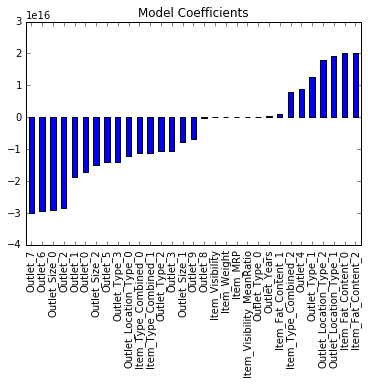

In [30]:
coef1 = pd.Series(model_lr.coef_, features).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')
plt.show()

### Ridge Regression Model


Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 44.6 | Min - 1076 | Max - 1217


C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


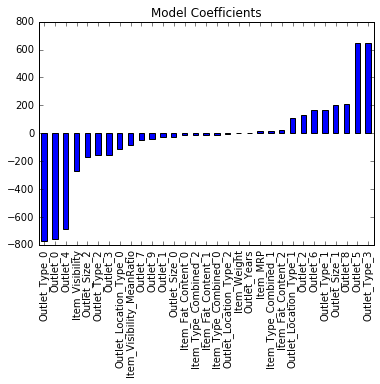

In [31]:
model_ridge = Ridge(alpha=0.05,normalize=True)
model_ridge.fit(train[features], train[target])

#prediction on training data
model_ridge_train_prediction = model_ridge.predict(train[features])

#Perform cross-validation:
cv_score = cross_val_score(model_ridge, train[features], train[target], cv=20, scoring='mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))

#Print model report:
print("\nModel Report")
print("RMSE : %.4g" % np.sqrt(mean_squared_error(train[target].values, model_ridge_train_prediction)))
print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),
                                                                  np.max(cv_score)))

#prediction on test data
test[target] = model_lr.predict(test[features])

#Export submission file:
IDcol.append(target)
submission = pd.DataFrame({ x: test[x] for x in IDcol})
submission.to_csv("model_ridge_01.csv", index=False)

coef2 = pd.Series(model_ridge.coef_, features).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

### Decision Tree Model


Model Report
RMSE : 1058
CV Score : Mean - 1091 | Std - 45.42 | Min - 1003 | Max - 1186


C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


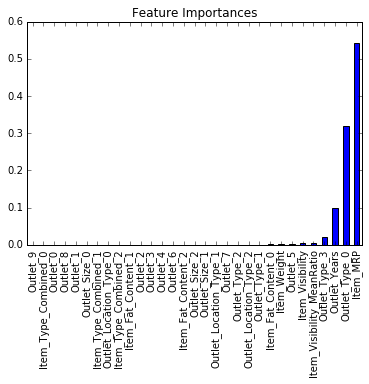

In [32]:
model_dt = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
model_dt.fit(train[features], train[target])

#prediction on training data
model_dt_train_prediction = model_dt.predict(train[features])

#Perform cross-validation:
cv_score = cross_val_score(model_dt, train[features], train[target], cv=20, scoring='mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))

#Print model report:
print("\nModel Report")
print("RMSE : %.4g" % np.sqrt(mean_squared_error(train[target].values, model_dt_train_prediction)))
print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),
                                                                  np.max(cv_score)))

#prediction on test data
test[target] = model_dt.predict(test[features])

#Export submission file:
IDcol.append(target)
submission = pd.DataFrame({ x: test[x] for x in IDcol})
submission.to_csv("model_dt_01.csv", index=False)

coef2 = pd.Series(model_dt.feature_importances_, features).sort_values()
coef2.plot(kind='bar', title='Feature Importances')


Model Report
RMSE : 1070
CV Score : Mean - 1095 | Std - 42.52 | Min - 1021 | Max - 1172


C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


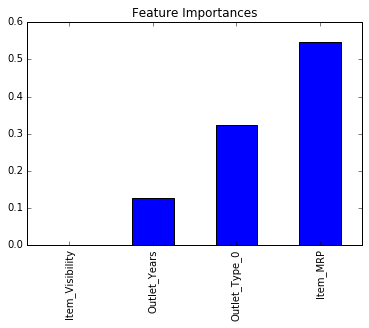

In [33]:
features = ['Item_MRP','Outlet_Type_0','Item_Visibility','Outlet_Years']
model_dt2 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
model_dt2.fit(train[features], train[target])

#prediction on training data
model_dt_train_prediction2 = model_dt2.predict(train[features])

#Perform cross-validation:
cv_score = cross_val_score(model_dt2, train[features], train[target], cv=20, scoring='mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))

#Print model report:
print("\nModel Report")
print("RMSE : %.4g" % np.sqrt(mean_squared_error(train[target].values, model_dt_train_prediction2)))
print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),
                                                                  np.max(cv_score)))

#prediction on test data
test[target] = model_dt2.predict(test[features])

#Export submission file:
IDcol.append(target)
submission = pd.DataFrame({ x: test[x] for x in IDcol})
submission.to_csv("model_dt_02.csv", index=False)

coef2 = pd.Series(model_dt2.feature_importances_, features).sort_values()
coef2.plot(kind='bar', title='Feature Importances')

### Random Forest


Model Report
RMSE : 1073
CV Score : Mean - 1084 | Std - 43.86 | Min - 1021 | Max - 1161


C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


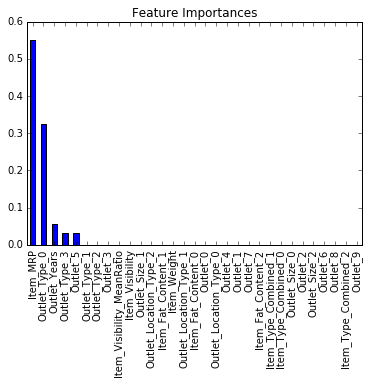

In [34]:
features = [x for x in train.columns if x not in [target]+IDcol]

model_rf = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
model_rf.fit(train[features], train[target])

#prediction on training data
model_rf_train_prediction = model_rf.predict(train[features])

#Perform cross-validation:
cv_score = cross_val_score(model_rf, train[features], train[target], cv=20, scoring='mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))

#Print model report:
print("\nModel Report")
print("RMSE : %.4g" % np.sqrt(mean_squared_error(train[target].values, model_rf_train_prediction)))
print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),
                                                                  np.max(cv_score)))

#prediction on test data
test[target] = model_rf.predict(test[features])

#Export submission file:
IDcol.append(target)
submission = pd.DataFrame({ x: test[x] for x in IDcol})
submission.to_csv("model_rf_01.csv", index=False)

coef2 = pd.Series(model_rf.feature_importances_, features).sort_values(ascending=False)
coef2.plot(kind='bar', title='Feature Importances')

## Fine tuning Random Forest with grid search

In [36]:
pipe_rf = Pipeline([('clf', RandomForestRegressor(random_state=1))])

#rf_gs = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)

max_depth_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n_estimators_range = [50, 100, 150, 200]
min_sample_leaf_range = [50, 100, 150, 200]

param_grid = [{'clf__max_depth': max_depth_range, 'clf__n_estimators': n_estimators_range, 
              'clf__min_samples_leaf': min_sample_leaf_range}]

gs = GridSearchCV(estimator=pipe_rf, 
                  param_grid=param_grid, 
                  scoring='r2', 
                  cv=10,
                  n_jobs=4)
gs = gs.fit(train[features], train[target])
print( gs.best_score_)
print(gs.best_params_)

gs_train_prediction = gs.predict(train[features])

#Print model report:
print("\nModel Report")
print("RMSE : %.4g" % np.sqrt(mean_squared_error(train[target].values, gs_train_prediction)))
print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),
                                                                  np.max(cv_score)))

0.597532100098
{'clf__n_estimators': 100, 'clf__max_depth': 6, 'clf__min_samples_leaf': 50}

Model Report
RMSE : 1061
CV Score : Mean - 1084 | Std - 43.86 | Min - 1021 | Max - 1161


In [37]:
#prediction on test data
test[target] = gs.predict(test[features])

#Export submission file:
IDcol.append(target)
submission = pd.DataFrame({ x: test[x] for x in IDcol})
submission.to_csv("model_gs_01.csv", index=False)

#coef2 = pd.Series(gs.feature_importances_, features).sort_values(ascending=False)
#coef2.plot(kind='bar', title='Feature Importances')

C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
